# 🧭 Sensor Modality – Setup
This notebook has been patched for portable paths (ROOT/DATA).

In [3]:
import pandas as pd

In [4]:
# Robust path setup (repo/Colab safe) 
import os, sys
from pathlib import Path

# Discover repo root (parent that contains src/)
NB_DIR = Path.cwd()
for cand in [NB_DIR, *NB_DIR.parents]:
    if (cand / "src").exists():
        sys.path.insert(0, str(cand))
        ROOT = cand
        break

# Import utilities
from src.utils import project_root, data_dir

ROOT = project_root()
DATA = data_dir()

print("Project root:", ROOT)
print("Data dir:", DATA)


Project root: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection
Data dir: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/data


In [5]:
from pathlib import Path

def sensor_out(*parts):
    p = ROOT / "outputs" / "sensor"
    p.mkdir(parents=True, exist_ok=True)
    return p.joinpath(*parts)

# Usage examples:
df = pd.read_csv(sensor_out("sensor_data_csh105_windowed_labeled.csv"))
df.to_csv(sensor_out("my_new_file.csv"), index=False)

In [6]:
!pip install xgboost

In [7]:
from pathlib import Path
from collections import Counter

# Auto-find the csh101 file under DATA
candidates = list(DATA.rglob("csh101/csh101.rawdata.txt"))
if not candidates:
    raise FileNotFoundError(
        f"Could not find csh101.rawdata.txt under DATA={DATA}\n"
        "Make sure the Kaggle sensor dataset is extracted into DATA/"
    )

rawdata_path = candidates[0]
print("Using file:", rawdata_path)

sensor_types_found = Counter()

with rawdata_path.open("r", encoding="utf-8", errors="ignore") as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) >= 7:
            sensor_type = parts[6]
            sensor_types_found[sensor_type] += 1

print("🧾 Unique sensor_type values in csh101:")
for s, count in sensor_types_found.items():
    print(f"{s}: {count}")

Using file: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/data/human+activity+recognition+from+continuous+ambient+sensor+data/csh101/csh101.rawdata.txt
🧾 Unique sensor_type values in csh101:
Control4-Door: 7198
Control4-Temperature: 34570
Control4-BatteryPercent: 12260
Control4-MotionArea: 498283
Control4-Motion: 780786
Control4-LightSensor: 542159


In [8]:
from pathlib import Path

# Auto-find csh101 rawdata file under DATA
candidates = list(DATA.rglob("csh101/csh101.rawdata.txt"))
if not candidates:
    raise FileNotFoundError(
        f"Could not find csh101.rawdata.txt under DATA={DATA}\n"
        "Make sure the Kaggle sensor dataset is extracted into DATA/"
    )

rawdata_path = candidates[0]
print("Using file:", rawdata_path)

with rawdata_path.open("r", encoding="utf-8", errors="ignore") as f:
    for _ in range(10):
        line = f.readline()
        print(" Raw Line:", line.strip())
        print(" Parts:", line.strip().split())
        print()

Using file: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/data/human+activity+recognition+from+continuous+ambient+sensor+data/csh101/csh101.rawdata.txt
 Raw Line: 2012-07-18 12:54:45.126257	D001	Ignore	Ignore	CLOSE	Control4-Door
 Parts: ['2012-07-18', '12:54:45.126257', 'D001', 'Ignore', 'Ignore', 'CLOSE', 'Control4-Door']

 Raw Line: 2012-07-18 12:54:45.196564	D002	OutsideDoor	FrontDoor	OPEN	Control4-Door
 Parts: ['2012-07-18', '12:54:45.196564', 'D002', 'OutsideDoor', 'FrontDoor', 'OPEN', 'Control4-Door']

 Raw Line: 2012-07-18 12:54:45.247825	T102	Ignore	FrontDoorTemp	78	Control4-Temperature
 Parts: ['2012-07-18', '12:54:45.247825', 'T102', 'Ignore', 'FrontDoorTemp', '78', 'Control4-Temperature']

 Raw Line: 2012-07-18 12:54:45.302398	BATP102	Ignore	Ignore	85	Control4-BatteryPercent
 Parts: ['2012-07-18', '12:54:45.302398', 'BATP102', 'Ignore', 'Ignore', '85', 'Control4-BatteryPercent']

 Raw Line: 2012-07-18 12:54:45.399416	T103	Ignore	BathroomTemp	25	Control4-Tempera

In [9]:
# --- Portable extraction of FIRST 3 DAYS for csh101/102/103 ---
from pathlib import Path
import pandas as pd
from datetime import datetime, timedelta

# Where outputs go (inside repo; safe for GitHub)
SENSOR_OUT = ROOT / "outputs" / "sensor"
SENSOR_OUT.mkdir(parents=True, exist_ok=True)

def parse_ts(s: str):
    """Parse timestamps with or without microseconds."""
    for fmt in ("%Y-%m-%d %H:%M:%S.%f", "%Y-%m-%d %H:%M:%S"):
        try:
            return datetime.strptime(s, fmt)
        except ValueError:
            pass
    return None

def split_line(line: str):
    """
    Try tab-separated first (dataset often uses tabs), fall back to whitespace.
    Returns list of fields.
    """
    parts = line.rstrip("\n").split("\t")
    if len(parts) < 6:
        parts = line.strip().split()
    return parts

def extract_first_n_days(input_path: Path, output_path: Path, days: int = 3):
    rows = []
    start_time = None

    with input_path.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if not line.strip():
                continue
            parts = split_line(line)
            if len(parts) < 6:
                continue

            ts = parse_ts(parts[0])
            if ts is None:
                continue

            if start_time is None:
                start_time = ts
            if ts - start_time > timedelta(days=days):
                break

            # Expected format (6 fields): ts, sensor, loc1, loc2, message, sensor_type
            # Be robust if extra fields: last field as sensor_type, next four as core
            sensor_type = parts[-1]
            core = parts[1:5]
            while len(core) < 4:
                core.append("")

            if sensor_type in {"Control4-Motion", "Control4-Door", "Control4-LightSensor"}:
                rows.append({
                    "timestamp": ts,
                    "sensor":   core[0],
                    "location1":core[1],
                    "location2":core[2],
                    "message":  core[3],
                    "sensor_type": sensor_type
                })

    df = pd.DataFrame(rows)
    df.to_csv(output_path, index=False)
    print(f"Extracted {len(df):,} rows from {input_path.name} → {output_path.name}")
    return df

def find_subject_file(subject: str) -> Path:
    """
    Auto-locate DATA/**/<subject>/<subject>.rawdata.txt
    Works regardless of parent folder name (with + or spaces).
    """
    hits = list(DATA.rglob(f"{subject}/{subject}.rawdata.txt"))
    if not hits:
        raise FileNotFoundError(
            f"Could not find {subject}.rawdata.txt under DATA={DATA}\n"
            "Make sure the Kaggle sensor dataset is extracted under DATA/"
        )
    return hits[0]

subjects = ["csh101", "csh102", "csh103"]
dfs = []

for subj in subjects:
    in_file = find_subject_file(subj)
    out_csv = SENSOR_OUT / f"{subj}_5days_cleaned.csv"
    df = extract_first_n_days(in_file, out_csv, days=5)  # <-- truly 5 days
    df["home"] = subj
    dfs.append(df)

# Combine and save inside outputs/sensor/
combined = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
combined_out = SENSOR_OUT / "sensor_data_csh101_103_5days_combined.csv"
combined.to_csv(combined_out, index=False)
print(f"\n Combined file saved as: {combined_out}")
print(f" Total rows combined: {len(combined):,}")

Extracted 14,971 rows from csh101.rawdata.txt → csh101_5days_cleaned.csv
Extracted 24,186 rows from csh102.rawdata.txt → csh102_5days_cleaned.csv
Extracted 5,201 rows from csh103.rawdata.txt → csh103_5days_cleaned.csv

 Combined file saved as: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_data_csh101_103_5days_combined.csv
 Total rows combined: 44,358


In [7]:
from pathlib import Path
import pandas as pd

# Define sensor outputs folder inside repo
SENSOR_OUT = ROOT / "outputs" / "sensor"
SENSOR_OUT.mkdir(parents=True, exist_ok=True)

# Paths
combined_path = SENSOR_OUT / "sensor_data_csh101_103_3days_combined.csv"
cleaned_path  = SENSOR_OUT / "sensor_data_csh101_103_3days_cleaned.csv"

# Load combined file
df = pd.read_csv(combined_path)

# Drop rows with missing values
df.dropna(inplace=True)

# Ensure timestamp column is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# Save cleaned version
df.to_csv(cleaned_path, index=False)

print(f"Cleaned file saved as: {cleaned_path}")
print(f"Rows after cleaning: {len(df):,}")

Cleaned file saved as: /Users/adarshthakur/Downloads/untitled folder/outputs/sensor/sensor_data_csh101_103_3days_cleaned.csv
Rows after cleaning: 44,358


In [10]:
from pathlib import Path
import pandas as pd

# Folder for sensor outputs
SENSOR_OUT = ROOT / "outputs" / "sensor"
SENSOR_OUT.mkdir(parents=True, exist_ok=True)

# Input: prefer cleaned file if available, else combined
combined_path = SENSOR_OUT / "sensor_data_csh101_103_3days_combined.csv"
cleaned_path  = SENSOR_OUT / "sensor_data_csh101_103_3days_cleaned.csv"
in_path = cleaned_path if cleaned_path.exists() else combined_path

print("Using input:", in_path)

# Load 
df = pd.read_csv(in_path)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"])

#  Set timestamp as index 
df = df.set_index("timestamp")

# Group by home and 30-second window 
windowed = df.groupby(
    ["home", pd.Grouper(freq="30s")]
).agg({
    "sensor_type": "count",                      # total events in window
    "message": lambda x: (x == "ON").sum()       # ON event count
}).rename(columns={
    "sensor_type": "event_count",
    "message": "on_count"
})

# Label as intrusion if ON events exceed threshold
THRESH = 3
windowed["label"] = (windowed["on_count"] > THRESH).astype(int)

# Reset index
windowed = windowed.reset_index()

# Save 
out_path = SENSOR_OUT / "sensor_data_csh101_103_3days_windowed_labeled.csv"
windowed.to_csv(out_path, index=False)

# Print stats 
print(f"Windowed and labeled data saved to: {out_path}")
print("Label distribution:\n", windowed['label'].value_counts())
print("otal samples:", len(windowed))

Using input: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_data_csh101_103_3days_cleaned.csv
Windowed and labeled data saved to: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_data_csh101_103_3days_windowed_labeled.csv
Label distribution:
 label
0    8974
1    1182
Name: count, dtype: int64
otal samples: 10156


In [11]:
from pathlib import Path
import pandas as pd

# Folder for sensor outputs inside repo
SENSOR_OUT = ROOT / "outputs" / "sensor"
SENSOR_OUT.mkdir(parents=True, exist_ok=True)

# Input: prefer cleaned file if it exists, else use combined
combined_path = SENSOR_OUT / "sensor_data_csh101_103_3days_combined.csv"
cleaned_path  = SENSOR_OUT / "sensor_data_csh101_103_3days_cleaned.csv"
in_path = cleaned_path if cleaned_path.exists() else combined_path

print(" Using input:", in_path)

#  Load 
df = pd.read_csv(in_path)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"])

# Set timestamp as index 
df = df.set_index("timestamp")

# Group by home and 30-second window 
windowed = df.groupby(
    ["home", pd.Grouper(freq="30s")]
).agg({
    "sensor_type": "count",                 # total events in window
    "message": lambda x: (x == "ON").sum()  # ON event count
}).rename(columns={
    "sensor_type": "event_count",
    "message": "on_count"
})

# Label as intrusion if ON events exceed threshold
THRESH = 3
windowed["label"] = (windowed["on_count"] > THRESH).astype(int)

# Reset index
windowed = windowed.reset_index()

# === Save ===
out_path = SENSOR_OUT / "sensor_data_csh101_103_3days_windowed_labeled.csv"
windowed.to_csv(out_path, index=False)

# === Print stats ===
print(f"Windowed & labeled data saved to: {out_path}")
print("Label distribution:\n", windowed['label'].value_counts())
print("Total samples:", len(windowed))

 Using input: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_data_csh101_103_3days_cleaned.csv
Windowed & labeled data saved to: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_data_csh101_103_3days_windowed_labeled.csv
Label distribution:
 label
0    8974
1    1182
Name: count, dtype: int64
Total samples: 10156


In [12]:
from pathlib import Path
import pandas as pd

# Paths (inside repo)
SENSOR_OUT = ROOT / "outputs" / "sensor"
SENSOR_OUT.mkdir(parents=True, exist_ok=True)

# Prefer the cleaned file if it exists; otherwise fall back to combined
combined_path = SENSOR_OUT / "sensor_data_csh101_103_3days_combined.csv"
cleaned_path  = SENSOR_OUT / "sensor_data_csh101_103_3days_cleaned.csv"
in_path = cleaned_path if cleaned_path.exists() else combined_path

print("Using input:", in_path)

#  Load 
df = pd.read_csv(in_path)

# Ensure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"])

#  Set index 
df = df.set_index("timestamp")

#  Group by home and 30s window 
windowed = df.groupby(
    ["home", pd.Grouper(freq="30s")]
).agg({
    "sensor_type": "count",                 # total events in window
    "message": lambda x: (x == "ON").sum()  # number of ON events
}).rename(columns={
    "sensor_type": "event_count",
    "message": "on_count"
})

# Label as intrusion if ON events exceed threshold
THRESH = 3
windowed["label"] = (windowed["on_count"] > THRESH).astype(int)

# Reset index
windowed = windowed.reset_index()

# === Save ===
out_path = SENSOR_OUT / "sensor_data_csh101_103_3days_windowed_labeled.csv"
windowed.to_csv(out_path, index=False)

# Stats
print(f" Windowed & labeled data saved to: {out_path}")
print(" Label distribution:\n", windowed["label"].value_counts())
print(" Total samples:", len(windowed))

Using input: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_data_csh101_103_3days_cleaned.csv
 Windowed & labeled data saved to: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_data_csh101_103_3days_windowed_labeled.csv
 Label distribution:
 label
0    8974
1    1182
Name: count, dtype: int64
 Total samples: 10156


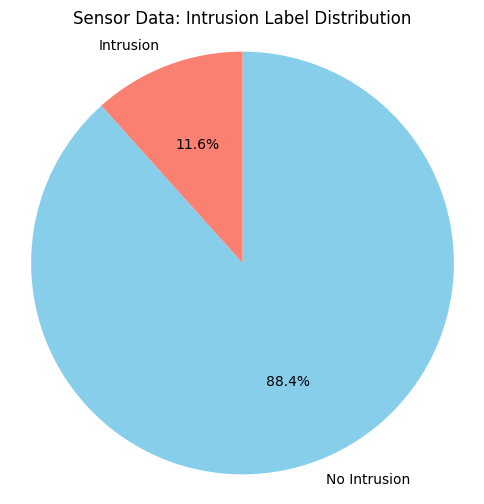

 Pie chart generated from: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_data_csh101_103_3days_windowed_labeled.csv
Counts: {0: 8974, 1: 1182}


In [13]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Sensor outputs folder inside repo
SENSOR_OUT = ROOT / "outputs" / "sensor"

# Use the windowed/labeled dataset we just saved
file_path = SENSOR_OUT / "sensor_data_csh101_103_3days_windowed_labeled.csv"

# Load labeled sensor data 
df = pd.read_csv(file_path)

# Count label occurrences 
label_counts = df["label"].value_counts().sort_index()

#  Prepare labels and colors 
labels = ['No Intrusion', 'Intrusion']
colors = ['skyblue', 'salmon']

# Plot pie chart 
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title("Sensor Data: Intrusion Label Distribution")
plt.axis('equal')  # Ensures the pie is a circle
plt.show()

print(" Pie chart generated from:", file_path)
print("Counts:", label_counts.to_dict())

In [14]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib

# Paths 
SENSOR_OUT = ROOT / "outputs" / "sensor"
SENSOR_OUT.mkdir(parents=True, exist_ok=True)

# Input dataset (windowed + labeled)
in_path = SENSOR_OUT / "sensor_data_csh101_103_3days_windowed_labeled.csv"

# Model output path
model_path = SENSOR_OUT / "xgboost_model_csh101_103_3days.pkl"

print("Using data from:", in_path)

#  Load labeled windowed data 
df = pd.read_csv(in_path)

#  Features and labels
X = df[["event_count", "on_count"]]  
y = df["label"]

# tratified Train-Test Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#  Train XGBoost 
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

#  Predict & Evaluate 
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# === Save model ===
joblib.dump(model, model_path)
print(f" Model saved as: {model_path}")

Using data from: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_data_csh101_103_3days_windowed_labeled.csv

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1796
           1     1.0000    1.0000    1.0000       236

    accuracy                         1.0000      2032
   macro avg     1.0000    1.0000    1.0000      2032
weighted avg     1.0000    1.0000    1.0000      2032


Confusion Matrix:
[[1796    0]
 [   0  236]]
 Model saved as: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/xgboost_model_csh101_103_3days.pkl


/opt/anaconda3/envs/shid_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [02:34:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [15]:
from pathlib import Path
import pandas as pd

# Folder for sensor outputs
SENSOR_OUT = ROOT / "outputs" / "sensor"
SENSOR_OUT.mkdir(parents=True, exist_ok=True)

# Auto-locate csh105 file inside DATA
candidates = list(DATA.rglob("csh105/csh105.rawdata.txt"))
if not candidates:
    raise FileNotFoundError(f"❌ Could not find csh105.rawdata.txt under {DATA}")
raw_file = candidates[0]
print("📂 Using:", raw_file)

# Output path
output_file = SENSOR_OUT / "csh105_3days_cleaned.csv"

# Load raw file
df = pd.read_csv(
    raw_file,
    sep="\t",
    header=None,
    names=["timestamp", "sensor", "location1", "location2", "message", "sensor_type"],
    on_bad_lines="skip"   # skip malformed rows
)

# Parse timestamps
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"])

# Keep only first 3 days
df = df[df["timestamp"] <= df["timestamp"].min() + pd.Timedelta(days=3)]

# Add home label
df["home"] = "csh105"

# Save
df.to_csv(output_file, index=False)
print(f"Extracted and saved 3 days from csh105 → {output_file}")
print(f" Rows: {len(df):,}")

📂 Using: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/data/human+activity+recognition+from+continuous+ambient+sensor+data/csh105/csh105.rawdata.txt
Extracted and saved 3 days from csh105 → /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/csh105_3days_cleaned.csv
 Rows: 18,568


In [16]:
from pathlib import Path
import pandas as pd

# Sensor outputs folder
SENSOR_OUT = ROOT / "outputs" / "sensor"
SENSOR_OUT.mkdir(parents=True, exist_ok=True)

# Input (cleaned csh105 file) & output (labeled windowed file)
in_path = SENSOR_OUT / "csh105_3days_cleaned.csv"
out_path = SENSOR_OUT / "sensor_data_csh105_windowed_labeled.csv"

# Load cleaned data 
df = pd.read_csv(in_path)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"])
df = df.set_index("timestamp")

# Windowing (30s windows) 
windowed = df.groupby(pd.Grouper(freq="30s")).agg({
    "sensor_type": "count",
    "message": lambda x: (x == "ON").sum(),
    "home": "first"
}).rename(columns={
    "sensor_type": "event_count",
    "message": "on_count"
})

# Labeling 
THRESH = 3
windowed["label"] = (windowed["on_count"] > THRESH).astype(int)

# Reset index
windowed = windowed.reset_index()

# Save final test file
windowed.to_csv(out_path, index=False)

print(f"Final test file created: {out_path}")
print("Label distribution:\n", windowed["label"].value_counts())
print("Total samples:", len(windowed))

Final test file created: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_data_csh105_windowed_labeled.csv
Label distribution:
 label
0    7837
1     731
Name: count, dtype: int64
Total samples: 8568


In [17]:
from pathlib import Path
import pandas as pd

# 1) ROOT/DATA must exist in this kernel
try:
    ROOT
except NameError:
    raise RuntimeError("ROOT is not defined. Run the setup cell that defines ROOT/DATA first.")

# 2) Standard location & filename
SENSOR_OUT = ROOT / "outputs" / "sensor"
expected = SENSOR_OUT / "sensor_data_csh105_windowed_labeled.csv"

print("CWD:", Path.cwd())
print("ROOT:", ROOT)
print("Expected:", expected)

# 3) Find the file robustly if not at the expected location
if not expected.exists():
    print("❗ Expected file not found. Searching under ROOT…")
    hits = list(ROOT.rglob("sensor_data_csh105_windowed_labeled*.csv"))
    for h in hits[:10]:
        print("  ↳ found:", h)
    if not hits:
        raise FileNotFoundError(
            "Could not find any 'sensor_data_csh105_windowed_labeled*.csv'. "
            "Make sure you ran the windowing cell that writes it."
        )
    # Prefer the standardized name if both exist
    candidates = [p for p in hits if p.name == "sensor_data_csh105_windowed_labeled.csv"]
    file_path = candidates[0] if candidates else hits[0]
else:
    file_path = expected

print("Using file:", file_path)

# 4) Load once and reuse 'df' below
df = pd.read_csv(file_path)
print("Rows:", len(df))
print("Columns:", list(df.columns))

CWD: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/notebooks
ROOT: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection
Expected: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_data_csh105_windowed_labeled.csv
Using file: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_data_csh105_windowed_labeled.csv
Rows: 8568
Columns: ['timestamp', 'event_count', 'on_count', 'home', 'label']


In [18]:
from pathlib import Path
import pandas as pd

# ---- Robust load of csh105 cleaned CSV ----
# Requires ROOT to be defined by your setup cell.
SENSOR_OUT = ROOT / "outputs" / "sensor"
expected = SENSOR_OUT / "csh105_3days_cleaned.csv"

print("ROOT:", ROOT)
print("Looking for:", expected)

if not expected.exists():
    print("❗ Not found at expected path. Searching under ROOT …")
    hits = list(ROOT.rglob("csh105_3days_cleaned*.csv"))
    for h in hits[:10]:
        print("  ↳ found:", h)
    if not hits:
        raise FileNotFoundError("Couldn't find csh105_3days_cleaned*.csv. Run the extract cell first.")
    in_path = hits[0]
else:
    in_path = expected

print(" Using file:", in_path)

# Load & window 
df = pd.read_csv(in_path)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"]).set_index("timestamp")

windowed = df.groupby(pd.Grouper(freq="30s")).agg({
    "sensor_type": "count",
    "message": lambda x: (x == "ON").sum(),
    "home": "first"
}).rename(columns={"sensor_type":"event_count","message":"on_count"})

# Labeling
THRESH = 3
windowed["label"] = (windowed["on_count"] > THRESH).astype(int)
windowed = windowed.reset_index()

# ---- Save to the standard location/name ----
out_path = SENSOR_OUT / "sensor_data_csh105_windowed_labeled.csv"
windowed.to_csv(out_path, index=False)

print(f"\n Final test file created: {out_path}")
print("Label distribution:\n", windowed["label"].value_counts())
print("Total samples:", len(windowed))

ROOT: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection
Looking for: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/csh105_3days_cleaned.csv
 Using file: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/csh105_3days_cleaned.csv

 Final test file created: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_data_csh105_windowed_labeled.csv
Label distribution:
 label
0    7837
1     731
Name: count, dtype: int64
Total samples: 8568


In [19]:
from pathlib import Path
import pandas as pd

# Sensor outputs folder
SENSOR_OUT = ROOT / "outputs" / "sensor"

# Input path
in_path = SENSOR_OUT / "csh105_3days_cleaned.csv"

# Load
df = pd.read_csv(in_path)

print(f" File: {in_path}")
print(f"Total rows in cleaned file: {len(df):,}")


 File: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/csh105_3days_cleaned.csv
Total rows in cleaned file: 18,568


In [20]:
from pathlib import Path
import pandas as pd

# Folder for sensor outputs
SENSOR_OUT = ROOT / "outputs" / "sensor"

# Input path (csh105 windowed & labeled file)
in_path = SENSOR_OUT / "sensor_data_csh105_windowed_labeled.csv"

# Load dataset
df = pd.read_csv(in_path)

# Check for label column
if "label" in df.columns:
    # Counts
    label_counts = df["label"].value_counts().sort_index()
    label_percent = df["label"].value_counts(normalize=True).sort_index() * 100

    print(f" File: {in_path}")
    print(" Label counts:\n", label_counts.to_dict())
    print("\nLabel distribution (%):\n", label_percent.round(2).to_dict())
else:
    print(" 'label' column not found. Please make sure the file has been windowed and labeled.")

 File: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_data_csh105_windowed_labeled.csv
 Label counts:
 {0: 7837, 1: 731}

Label distribution (%):
 {0: 91.47, 1: 8.53}


In [21]:
from pathlib import Path
import pandas as pd
import joblib
from sklearn.metrics import classification_report, confusion_matrix

# Paths
SENSOR_OUT = ROOT / "outputs" / "sensor"

unseen_path = SENSOR_OUT / "sensor_data_csh105_windowed_labeled.csv"
model_path  = SENSOR_OUT / "xgboost_model_csh101_103_3days.pkl"

#  Load unseen windowed + labeled data (csh105) 
unseen_df = pd.read_csv(unseen_path)

# Load trained model 
model = joblib.load(model_path)

# Prepare features & labels 
X_unseen = unseen_df[["event_count", "on_count"]]
y_unseen = unseen_df["label"]

#  Predict 
y_pred_unseen = model.predict(X_unseen)

# Evaluation 
print("\nEvaluation on Unseen Data (csh105):")
print(classification_report(y_unseen, y_pred_unseen, digits=4))

print("\n Confusion Matrix:")
print(confusion_matrix(y_unseen, y_pred_unseen))


Evaluation on Unseen Data (csh105):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      7837
           1     1.0000    1.0000    1.0000       731

    accuracy                         1.0000      8568
   macro avg     1.0000    1.0000    1.0000      8568
weighted avg     1.0000    1.0000    1.0000      8568


 Confusion Matrix:
[[7837    0]
 [   0  731]]


In [22]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Paths inside the repo 
SENSOR_OUT = ROOT / "outputs" / "sensor"
test_path  = SENSOR_OUT / "sensor_data_csh105_windowed_labeled.csv"   # standardized name
model_path = SENSOR_OUT / "xgboost_model_csh101_103_3days.pkl"

print("Using test data:", test_path)
print(" Using model   :", model_path)

# Load test data
df_test = pd.read_csv(test_path)

# Keep only the features your model was trained on
FEATURES = ["event_count", "on_count"]
missing = [c for c in FEATURES if c not in df_test.columns]
if missing:
    raise ValueError(f"Missing expected feature columns in test set: {missing}")

X_test = df_test[FEATURES]
y_test_original = df_test["label"].copy()

# Flip 5% of labels to simulate noise (reproducible) 
np.random.seed(42)
n_flip = max(1, int(0.05 * len(y_test_original)))
flip_indices = np.random.choice(y_test_original.index, size=n_flip, replace=False)
y_test_noisy = y_test_original.copy()
y_test_noisy.loc[flip_indices] = 1 - y_test_noisy.loc[flip_indices]

print(f" Introduced noise: flipped {n_flip} of {len(y_test_original)} labels (~5%).")

#  Load trained model 
model = joblib.load(model_path)

# Predict & Evaluate 
y_pred = model.predict(X_test)

print("\nEvaluation on Noisy Test Data (5% flipped):")
print(classification_report(y_test_noisy, y_pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_noisy, y_pred))

Using test data: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_data_csh105_windowed_labeled.csv
 Using model   : /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/xgboost_model_csh101_103_3days.pkl
 Introduced noise: flipped 428 of 8568 labels (~5%).

Evaluation on Noisy Test Data (5% flipped):
              precision    recall  f1-score   support

           0     0.9502    0.9949    0.9721      7485
           1     0.9480    0.6399    0.7641      1083

    accuracy                         0.9500      8568
   macro avg     0.9491    0.8174    0.8681      8568
weighted avg     0.9500    0.9500    0.9458      8568

Confusion Matrix:
[[7447   38]
 [ 390  693]]


In [23]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import joblib

#  Paths inside repo 
SENSOR_OUT = ROOT / "outputs" / "sensor"
test_path  = SENSOR_OUT / "sensor_data_csh105_windowed_labeled.csv"
model_path = SENSOR_OUT / "xgboost_model_csh101_103_3days.pkl"

print("Using test data:", test_path)
print(" Using model   :", model_path)

# Load test data 
df_test = pd.read_csv(test_path)

# Features and labels
FEATURES = ["event_count", "on_count"]
X_test = df_test[FEATURES].copy()
y_test = df_test["label"]

#  Add Gaussian Noise to simulate sensor imprecision 
noise_strength = 0.1   # adjust: 0.2 or 0.3 for stronger noise
np.random.seed(42)
X_test_noisy = X_test.copy()
for col in FEATURES:
    X_test_noisy[col] += np.random.normal(0, noise_strength, size=len(X_test))

print(f"Added Gaussian noise (σ={noise_strength}) to {FEATURES}")

#  Load trained model 
model = joblib.load(model_path)

# Predict & Evaluate 
y_pred = model.predict(X_test_noisy)

print("\nEvaluation on Sensor Feature Noise Test Data:")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Using test data: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_data_csh105_windowed_labeled.csv
 Using model   : /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/xgboost_model_csh101_103_3days.pkl
Added Gaussian noise (σ=0.1) to ['event_count', 'on_count']

Evaluation on Sensor Feature Noise Test Data:
              precision    recall  f1-score   support

           0     0.9898    1.0000    0.9949      7837
           1     1.0000    0.8892    0.9413       731

    accuracy                         0.9905      8568
   macro avg     0.9949    0.9446    0.9681      8568
weighted avg     0.9906    0.9905    0.9903      8568

Confusion Matrix:
[[7837    0]
 [  81  650]]


 Train (101–103): /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_data_csh101_103_3days_windowed_labeled.csv
 Unseen (105):    /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_data_csh105_windowed_labeled.csv
Model:           /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/xgboost_model_csh101_103_3days.pkl

 Clean split (from 101–103):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1796
           1     1.0000    1.0000    1.0000       236

    accuracy                         1.0000      2032
   macro avg     1.0000    1.0000    1.0000      2032
weighted avg     1.0000    1.0000    1.0000      2032


 Unseen home (csh105):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      7837
           1     1.0000    1.0000    1.0000       731

    accuracy                         1.0000      856

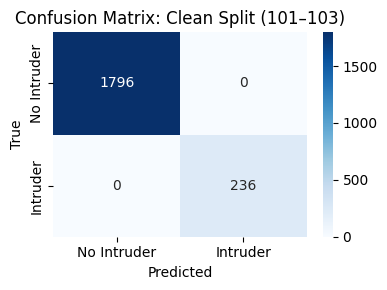

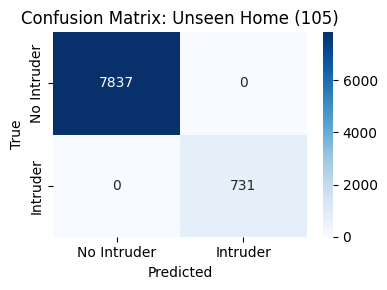

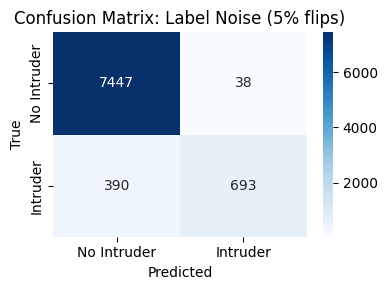

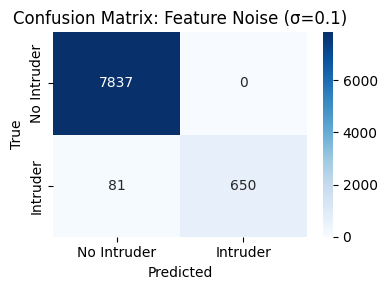

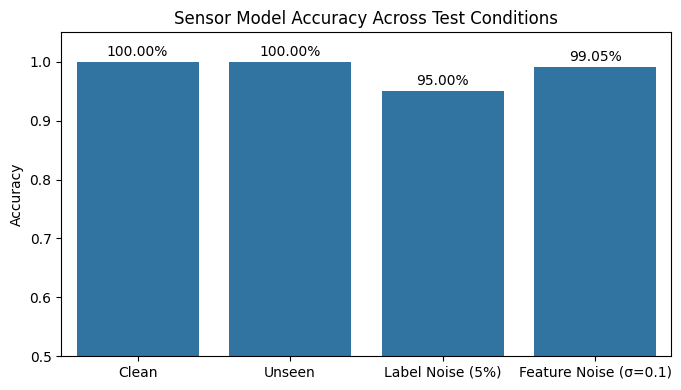

In [24]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# === Paths inside the repo (portable) ===
SENSOR_OUT = ROOT / "outputs" / "sensor"
train_path = SENSOR_OUT / "sensor_data_csh101_103_3days_windowed_labeled.csv"
unseen_path = SENSOR_OUT / "sensor_data_csh105_windowed_labeled.csv"
model_path = SENSOR_OUT / "xgboost_model_csh101_103_3days.pkl"

print(" Train (101–103):", train_path)
print(" Unseen (105):   ", unseen_path)
print("Model:          ", model_path)

# Load model 
model = joblib.load(model_path)

# Load clean train data (we'll take a clean held-out split from this) 
df_train = pd.read_csv(train_path)
FEATURES = ["event_count", "on_count"]
X_train_all = df_train[FEATURES]
y_train_all = df_train["label"]

# Clean test split from train homes (csh101–103)
X_tr, X_clean_test, y_tr, y_clean_test = train_test_split(
    X_train_all, y_train_all, test_size=0.2, random_state=42, stratify=y_train_all
)
y_pred_clean = model.predict(X_clean_test)
cm_clean = confusion_matrix(y_clean_test, y_pred_clean)

print("\n Clean split (from 101–103):")
print(classification_report(y_clean_test, y_pred_clean, digits=4))

# === Load unseen home (csh105) ===
df_unseen = pd.read_csv(unseen_path)
X_unseen = df_unseen[FEATURES]
y_unseen = df_unseen["label"]
y_pred_unseen = model.predict(X_unseen)
cm_unseen = confusion_matrix(y_unseen, y_pred_unseen)

print("\n Unseen home (csh105):")
print(classification_report(y_unseen, y_pred_unseen, digits=4))

# === 5% label flip noise on unseen labels ===
np.random.seed(42)
y_noisy_labels = y_unseen.copy()
flip_n = max(1, int(0.05 * len(y_noisy_labels)))
flip_idx = np.random.choice(y_noisy_labels.index, size=flip_n, replace=False)
y_noisy_labels.loc[flip_idx] = 1 - y_noisy_labels.loc[flip_idx]
y_pred_label_noisy = model.predict(X_unseen)
cm_label_noise = confusion_matrix(y_noisy_labels, y_pred_label_noisy)

print(f"\n🧪 Unseen with 5% label flips (n={flip_n}):")
print(classification_report(y_noisy_labels, y_pred_label_noisy, digits=4))

# Add Gaussian noise to features on unseen set 
np.random.seed(42)
sigma = 0.1  # try 0.1; increase to 0.2/0.3 to stress more
X_unseen_gaussian = X_unseen.copy()
for col in FEATURES:
    X_unseen_gaussian[col] += np.random.normal(0, sigma, size=len(X_unseen_gaussian))

y_pred_feature_noisy = model.predict(X_unseen_gaussian)
cm_feature_noise = confusion_matrix(y_unseen, y_pred_feature_noisy)

print(f"\n🧪 Unseen with Gaussian feature noise (σ={sigma}):")
print(classification_report(y_unseen, y_pred_feature_noisy, digits=4))

# Plot Confusion Matrices 
def plot_cm(cm, title):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Intruder", "Intruder"],
                yticklabels=["No Intruder", "Intruder"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_cm(cm_clean,          "Confusion Matrix: Clean Split (101–103)")
plot_cm(cm_unseen,         "Confusion Matrix: Unseen Home (105)")
plot_cm(cm_label_noise,    "Confusion Matrix: Label Noise (5% flips)")
plot_cm(cm_feature_noise,  "Confusion Matrix: Feature Noise (σ=0.1)")

# Accuracy Bar Chart 
def accuracy(cm):
    return (cm[0,0] + cm[1,1]) / cm.sum()

accs = [
    accuracy(cm_clean),
    accuracy(cm_unseen),
    accuracy(cm_label_noise),
    accuracy(cm_feature_noise)
]
labels = ["Clean", "Unseen", "Label Noise (5%)", "Feature Noise (σ=0.1)"]

plt.figure(figsize=(7, 4))
sns.barplot(x=labels, y=accs)
plt.ylim(0.5, 1.05)
plt.ylabel("Accuracy")
plt.title("Sensor Model Accuracy Across Test Conditions")
for i, acc in enumerate(accs):
    plt.text(i, acc + 0.01, f"{acc:.2%}", ha='center')
plt.tight_layout()
plt.show()

In [25]:
from pathlib import Path
import pandas as pd
import joblib

#  Paths 
SENSOR_OUT = ROOT / "outputs" / "sensor"
model_path = SENSOR_OUT / "xgboost_model_csh101_103_3days.pkl"
test_path  = SENSOR_OUT / "sensor_data_csh105_windowed_labeled.csv"
out_path   = SENSOR_OUT / "sensor_probs.csv"

print(" Model:", model_path)
print("Test data:", test_path)

#  Load model 
model = joblib.load(model_path)

# Load test data 
df_test = pd.read_csv(test_path)
X_new = df_test[["event_count", "on_count"]]

#  Predict probabilities 
y_pred_proba = model.predict_proba(X_new)  # shape (N, 2)

#  Save to fusion format 
sensor_probs = pd.DataFrame(
    y_pred_proba,
    columns=["sensor_p_normal", "sensor_p_intrusion"]
)
sensor_probs.to_csv(out_path, index=False)

print(f" Sensor probabilities saved to: {out_path}")
print(sensor_probs.head())

 Model: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/xgboost_model_csh101_103_3days.pkl
Test data: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_data_csh105_windowed_labeled.csv
 Sensor probabilities saved to: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_probs.csv
   sensor_p_normal  sensor_p_intrusion
0         0.999873            0.000127
1         0.999873            0.000127
2         0.999873            0.000127
3         0.999873            0.000127
4         0.999873            0.000127


In [26]:
from pathlib import Path
import pandas as pd
import numpy as np

# === Paths ===
SENSOR_OUT = ROOT / "outputs" / "sensor"
sensor_probs_path = SENSOR_OUT / "sensor_probs.csv"

print("📂 Loading sensor probabilities from:", sensor_probs_path)

# Load the updated sensor probabilities
sdf = pd.read_csv(sensor_probs_path)

# Candidate column names to locate p(normal) and p(intrusion)
cand_pairs = [
    ("sensor_p_normal","sensor_p_intrusion"),
    ("p_normal","p_intrusion"),
    ("normal","intrusion")
]

for a, b in cand_pairs:
    if a in sdf.columns and b in sdf.columns:
        s_norm = sdf[a].astype(float).to_numpy()
        s_intr = sdf[b].astype(float).to_numpy()
        break
else:
    raise ValueError("❌ Could not find valid normal/intrusion columns in sensor_probs.csv")

# Classes for mapping ( matched with those used in AUDIO and VIDEO)
CLASSES = ["dog","door_wood_knock","footsteps","glassbreak","gunshot","siren"]

# Convert each (p_normal, p_intrusion) pair to 6-class vector
def sensor_to_p6(pn, pi):
    p6 = np.zeros(len(CLASSES), float)
    # Normal -> "dog"
    p6[CLASSES.index("dog")] = pn
    # Intrusion -> split evenly across the 5 intrusion classes
    share = pi / 5.0
    for i, c in enumerate(CLASSES):
        if c != "dog":
            p6[i] = share
    s = p6.sum()
    return p6 if s == 0 else p6 / s

# Apply mapping
S_all = np.vstack([sensor_to_p6(pn, pi) for pn, pi in zip(s_norm, s_intr)])

print(f"✅ Sensor mapped to shape: {S_all.shape} (should be Nx6)")
print("📊 Sample row (probabilities across 6 classes):")
print(S_all[0])

📂 Loading sensor probabilities from: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/sensor/sensor_probs.csv
✅ Sensor mapped to shape: (8568, 6) (should be Nx6)
📊 Sample row (probabilities across 6 classes):
[9.99873285e-01 2.53429116e-05 2.53429116e-05 2.53429116e-05
 2.53429116e-05 2.53429116e-05]
